# ETL : CSV -> S3 -> DB

In [46]:
import pandas as pd 
import boto3
from sqlalchemy import create_engine
from datetime import datetime

from etl import compute_weather_score

from utils import (
    df_postgres_upsert,
    read_df_from_jsonlines
)

from config import (
    secrets,
    S3_BUCKET_NAME,
    POSTGRES_DB_URL,
    CITIES_GEO_LOCATION_CSV_PATH,
    CITIES_WEATHER_FORECAST_CSV_PATH,
    CITIES_GEO_LOCATION_AND_SCORE_CSV_PATH,
    BEST_HOTELS_OF_CITIES_JSON_PATH,
)

## Stockage vers un bucket S3

Le bucket utilisé est provisionné via le provisionning Terraform (cf. [howto deploy infra](../../common/aws/howto.md)).


In [ ]:
session = boto3.Session(aws_access_key_id=secrets["AWS_ACCESS_KEY_ID"], 
                        aws_secret_access_key=secrets["AWS_ACCESS_KEY_SECRET"])

s3_client = session.client("s3")

In [30]:
# destinations with geo locations CSV
s3_client.upload_file(CITIES_GEO_LOCATION_CSV_PATH, S3_BUCKET_NAME, f"b1-kayak/{CITIES_GEO_LOCATION_CSV_PATH.name}")
# weather forecast for all cities
s3_client.upload_file(CITIES_WEATHER_FORECAST_CSV_PATH, S3_BUCKET_NAME, f"b1-kayak/{CITIES_WEATHER_FORECAST_CSV_PATH.name}")
# cities with geo location and weather related scores
s3_client.upload_file(CITIES_GEO_LOCATION_AND_SCORE_CSV_PATH, S3_BUCKET_NAME, f"b1-kayak/{CITIES_GEO_LOCATION_AND_SCORE_CSV_PATH.name}")
# best hotels per cities
s3_client.upload_file(BEST_HOTELS_OF_CITIES_JSON_PATH, S3_BUCKET_NAME, f"b1-kayak/{BEST_HOTELS_OF_CITIES_JSON_PATH.name}")

### Contenu du bucket S3

[s3_content_b1-kayak.png](./assets/s3_content_b1-kayak.png):

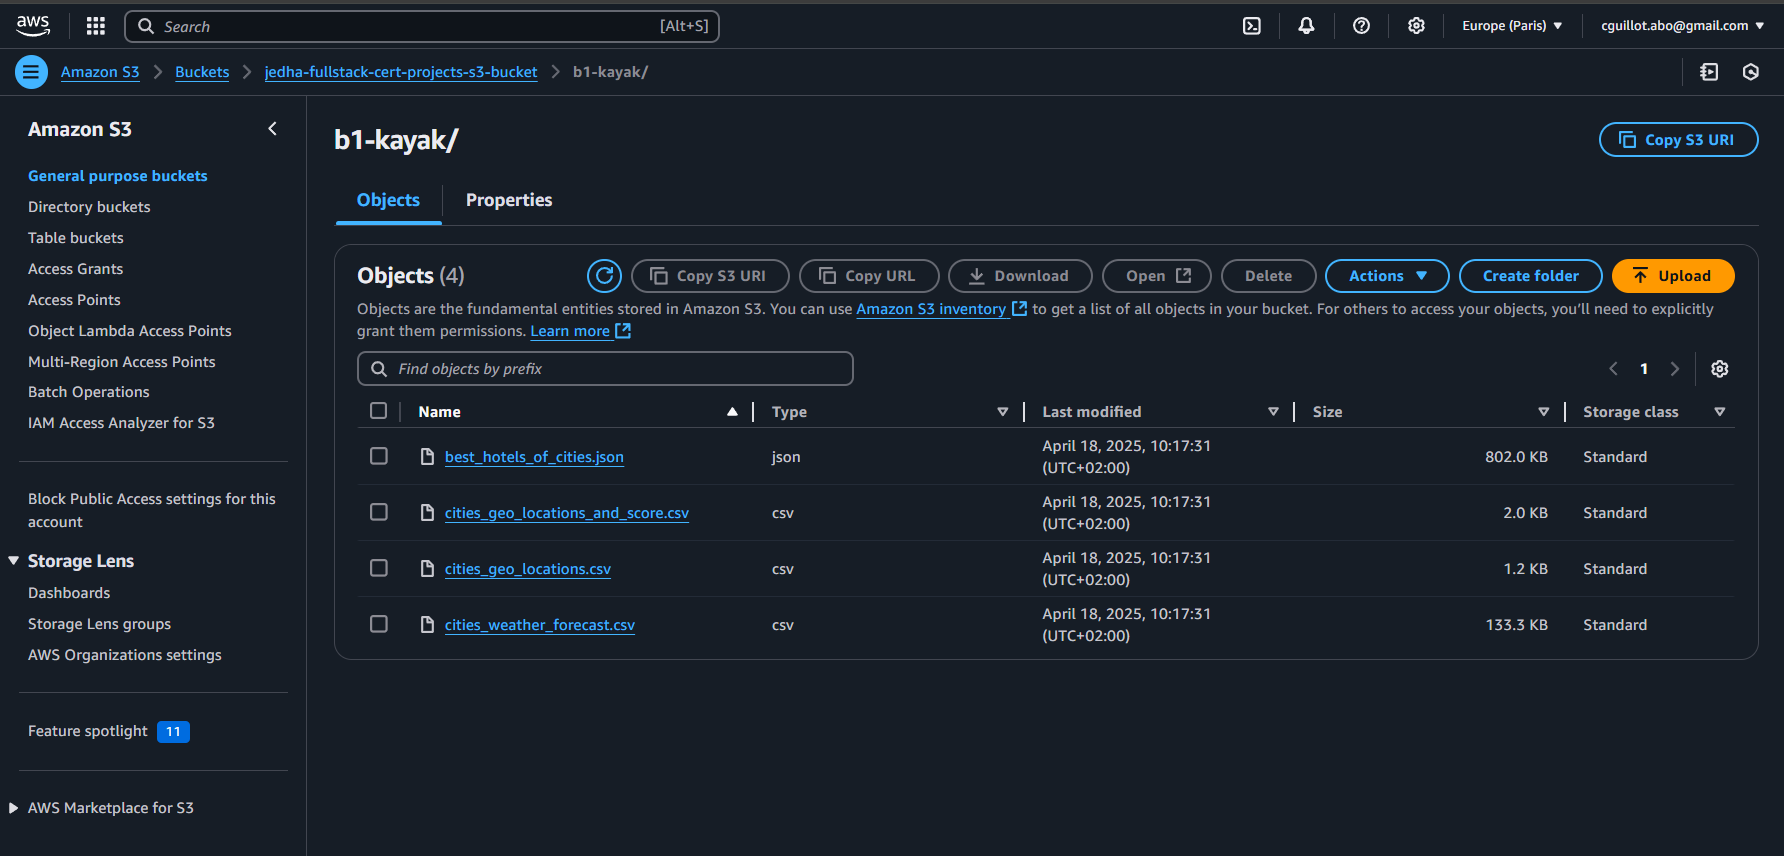


## Stockage en Database
### Création de la DB

Les données sont structurées de manière à limiter les tables modifiées fréquemment. Une table est dédiée au forecast lié à la météo, les tables `city` et `hotel` changeront rarement.

Script de création:
```sql
CREATE TABLE "city" (
  "id" int PRIMARY KEY,
  "name" varchar,
  "latitude" DECIMAL(9,6),
  "longitude" DECIMAL(9,6),
  "created_at" TIMESTAMP DEFAULT (now()),
  "updated_at" TIMESTAMP DEFAULT (now())
);

CREATE TABLE "hotel" (
  "id" int PRIMARY KEY,
  "city_id" int,
  "name" varchar,
  "review_appreciation" varchar,
  "review_score" DECIMAL(10,2),
  "rating_stars" int,
  "description" text,
  "latitude" DECIMAL(9,6),
  "longitude" DECIMAL(9,6),
  "url" varchar,
  "rating_squares" int,
  "created_at" TIMESTAMP DEFAULT (now()),
  "updated_at" TIMESTAMP DEFAULT (now())
);

CREATE TABLE "weather_forecast_score" (
  "city_id" int,
  "score_date" date,
  "temperature" DECIMAL(6,2),
  "min_pop" DECIMAL(6,2),
  "mean_pop" DECIMAL(6,2),
  "max_pop" DECIMAL(6,2),
  "created_at" TIMESTAMP DEFAULT (now()),
  PRIMARY KEY ("city_id", "score_date")
);

ALTER TABLE "hotel" ADD FOREIGN KEY ("city_id") REFERENCES "city" ("id");

ALTER TABLE "weather_forecast_score" ADD FOREIGN KEY ("city_id") REFERENCES "city" ("id");
```

### Schéma

[b1-kayak-db.png](./assets/b1-kayak-db.png):

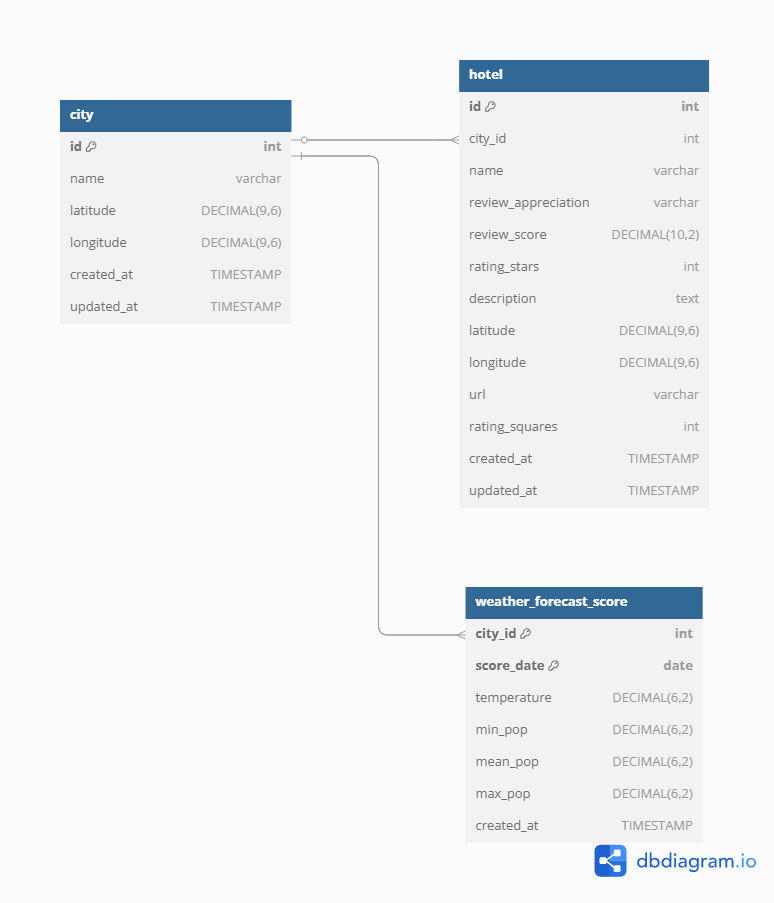


### CSV -> DB

In [31]:
# Init DB engine    
db_engine = create_engine(POSTGRES_DB_URL, echo=True)

In [32]:
# cities with location
cities_df = pd.read_csv(CITIES_GEO_LOCATION_CSV_PATH)
cities_df.to_sql("city", db_engine, if_exists="append", index=False, method=postgres_upsert)

2025-04-18 11:27:10,336 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-04-18 11:27:10,337 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-04-18 11:27:10,337 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-04-18 11:27:10,373 INFO sqlalchemy.engine.Engine select current_schema()
2025-04-18 11:27:10,374 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-04-18 11:27:10,410 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-04-18 11:27:10,412 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-04-18 11:27:10,442 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-18 11:27:10,446 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_cat

[b1-kayak-neondb-cities.png](assets/b1-kayak-neondb-cities.png):

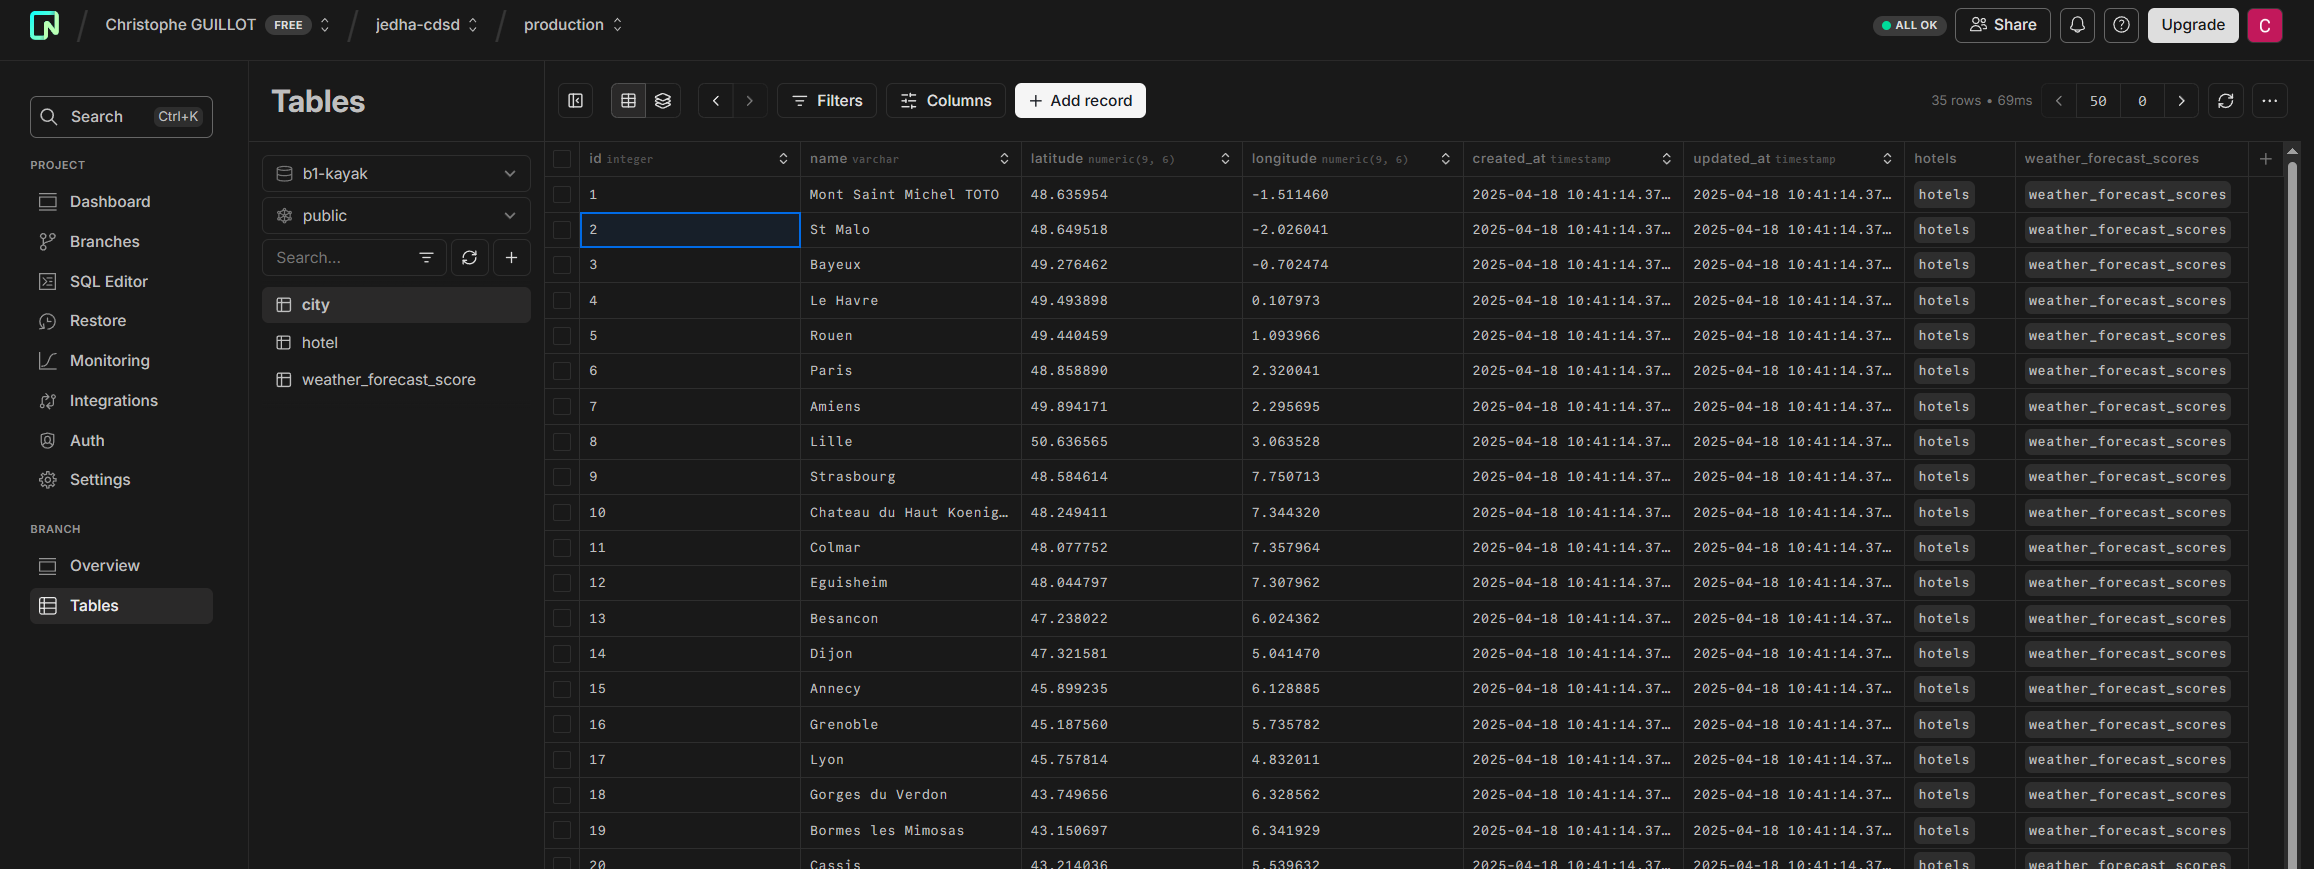

In [33]:
# hotels
hotels_df = read_df_from_jsonlines(BEST_HOTELS_OF_CITIES_JSON_PATH)
hotels_df.rename(columns={"geo_latitude": "latitude", "geo_longitude": "longitude"}, inplace=True)

hotels_df.to_sql("hotel", db_engine, if_exists="append", index=False, method=df_postgres_upsert)

2025-04-18 11:27:10,605 INFO sqlalchemy.engine.Engine BEGIN (implicit)


2025-04-18 11:27:10,609 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-04-18 11:27:10,611 INFO sqlalchemy.engine.Engine [cached since 0.1654s ago] {'table_name': 'hotel', 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2025-04-18 11:27:10,611 INFO sqlalchemy.engine.Engine [cached since 0.1654s ago] {'table_name': 'hotel', 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2025-04-18 11:27:11,017 INFO sqlalchemy.engine.Engine INSERT INTO hotel (id, city_id, name

[data view](assets/b1-kayak-neondb-hotels-of-city.png):

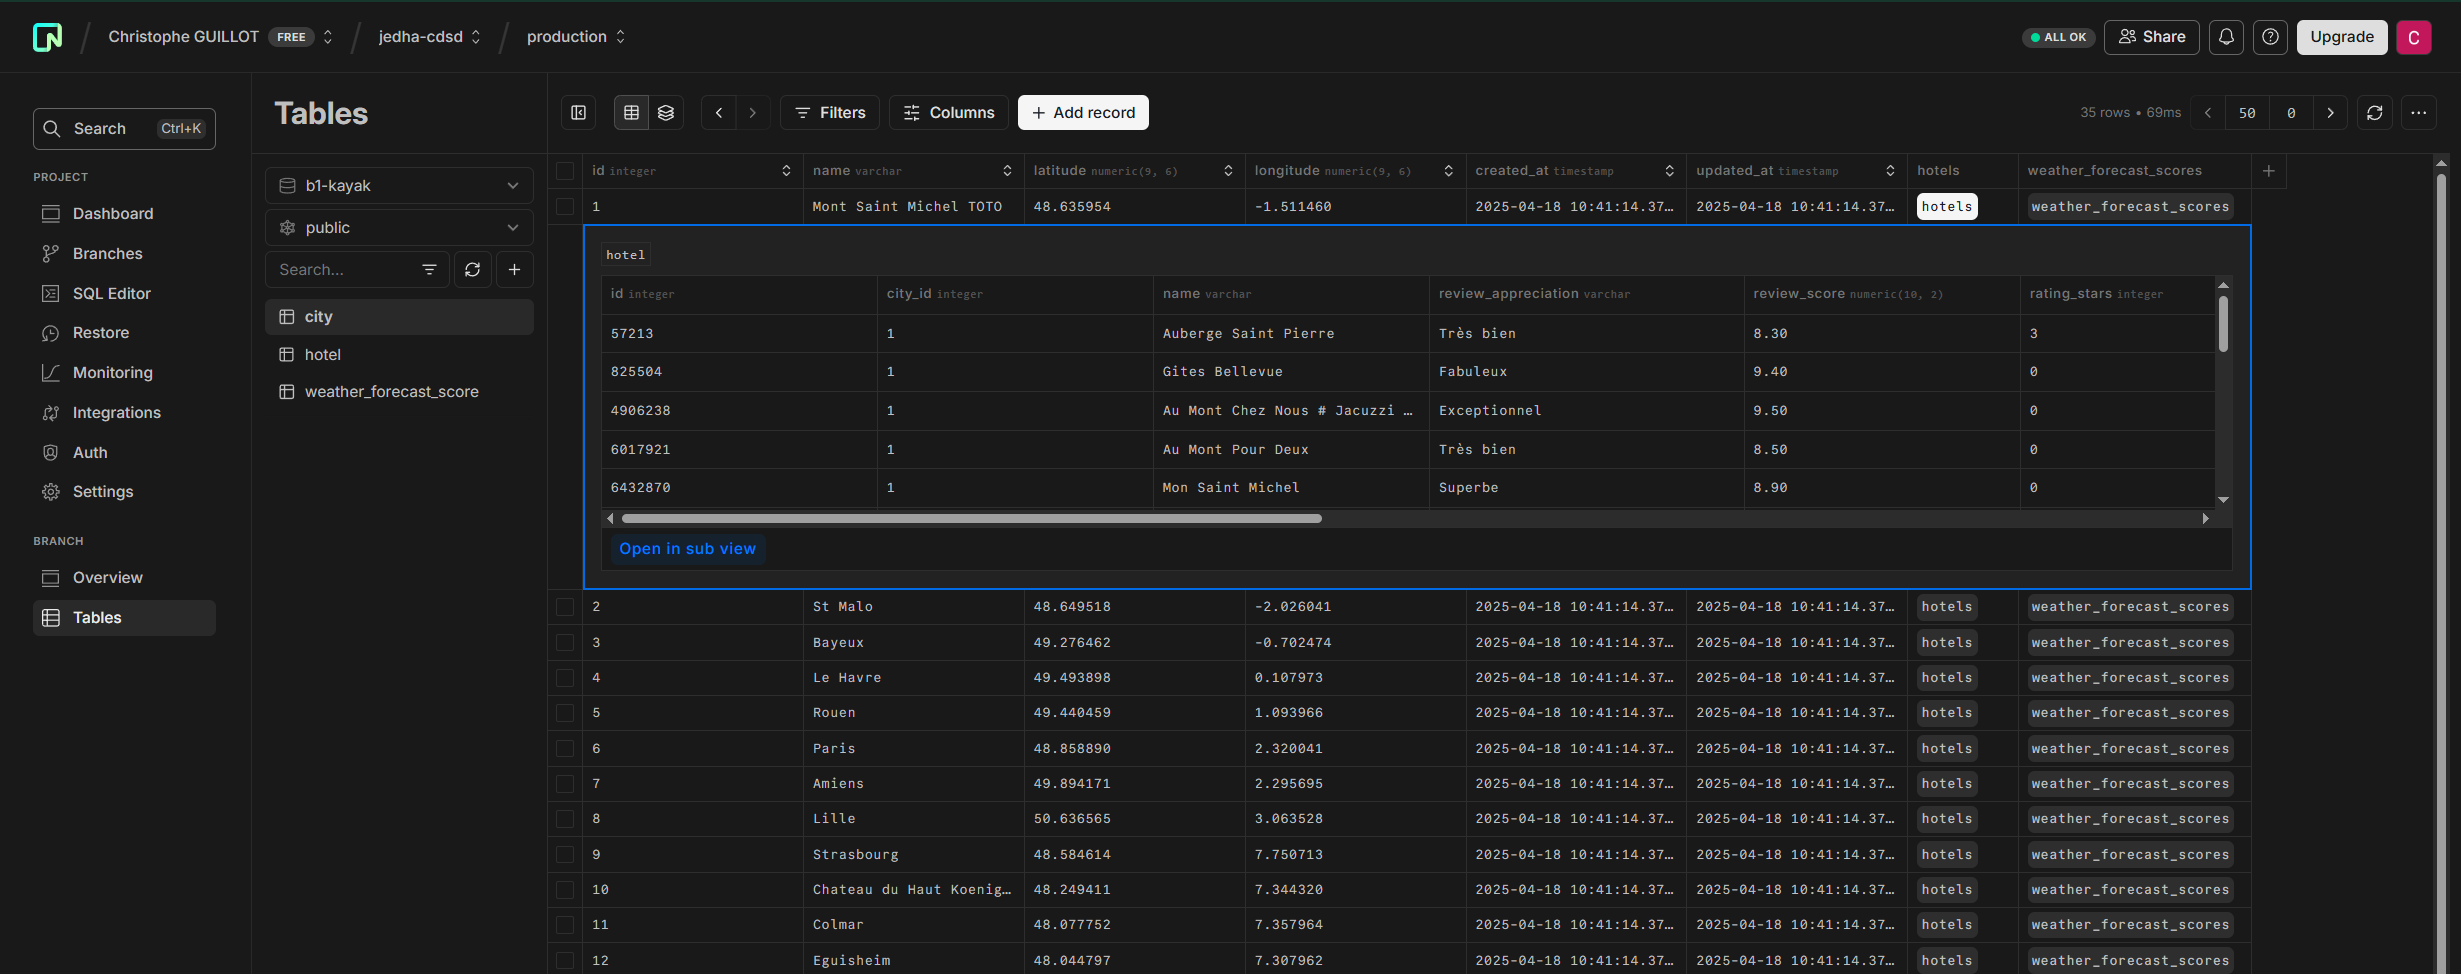

In [47]:
# Weather forecast
cities_weather_forecast_df = pd.read_csv(CITIES_WEATHER_FORECAST_CSV_PATH)
# convert dt to datetime type
cities_weather_forecast_df.dt = pd.to_datetime(cities_weather_forecast_df.dt)

# Compute scoring values
scoring_df = compute_weather_score(cities_weather_forecast_df)

scoring_df.rename(columns={"mean_temp": "temperature"}, inplace=True)

# set date of today
scoring_df["score_date"] = datetime.now().date()

scoring_df.to_sql("weather_forecast_score", con=db_engine, if_exists='append', index=False, method=df_postgres_upsert)

2025-04-18 11:35:35,560 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-04-18 11:35:35,563 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2025-04-18 11:35:35,565 INFO sqlalchemy.engine.Engine [cached since 554.2s ago] {'table_name': 'weather_forecast_score', 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}


2025-04-18 11:35:35,629 INFO sqlalchemy.engine.Engine INSERT INTO weather_forecast_score (city_id, temperature, min_pop, mean_pop, max_pop, score_date) VALUES (%(city_id_m0)s, %(temperature_m0)s, %(min_pop_m0)s, %(mean_pop_m0)s, %(max_pop_m0)s, %(score_date_m0)s), (%(city_id_m1)s, %(temperature_m1)s, %(min_pop_m1)s, %(mean_pop_m1)s, %(max_pop_m1)s, %(score_date_m1)s), (%(city_id_m2)s, %(temperature_m2)s, %(min_pop_m2)s, %(mean_pop_m2)s, %(max_pop_m2)s, %(score_date_m2)s), (%(city_id_m3)s, %(temperature_m3)s, %(min_pop_m3)s, %(mean_pop_m3)s, %(max_pop_m3)s, %(score_date_m3)s), (%(city_id_m4)s, %(temperature_m4)s, %(min_pop_m4)s, %(mean_pop_m4)s, %(max_pop_m4)s, %(score_date_m4)s), (%(city_id_m5)s, %(temperature_m5)s, %(min_pop_m5)s, %(mean_pop_m5)s, %(max_pop_m5)s, %(score_date_m5)s), (%(city_id_m6)s, %(temperature_m6)s, %(min_pop_m6)s, %(mean_pop_m6)s, %(max_pop_m6)s, %(score_date_m6)s), (%(city_id_m7)s, %(temperature_m7)s, %(min_pop_m7)s, %(mean_pop_m7)s, %(max_pop_m7)s, %(score_date_

[b1-kayak-neondb-score-of-city.png](assets/b1-kayak-neondb-score-of-city.png)

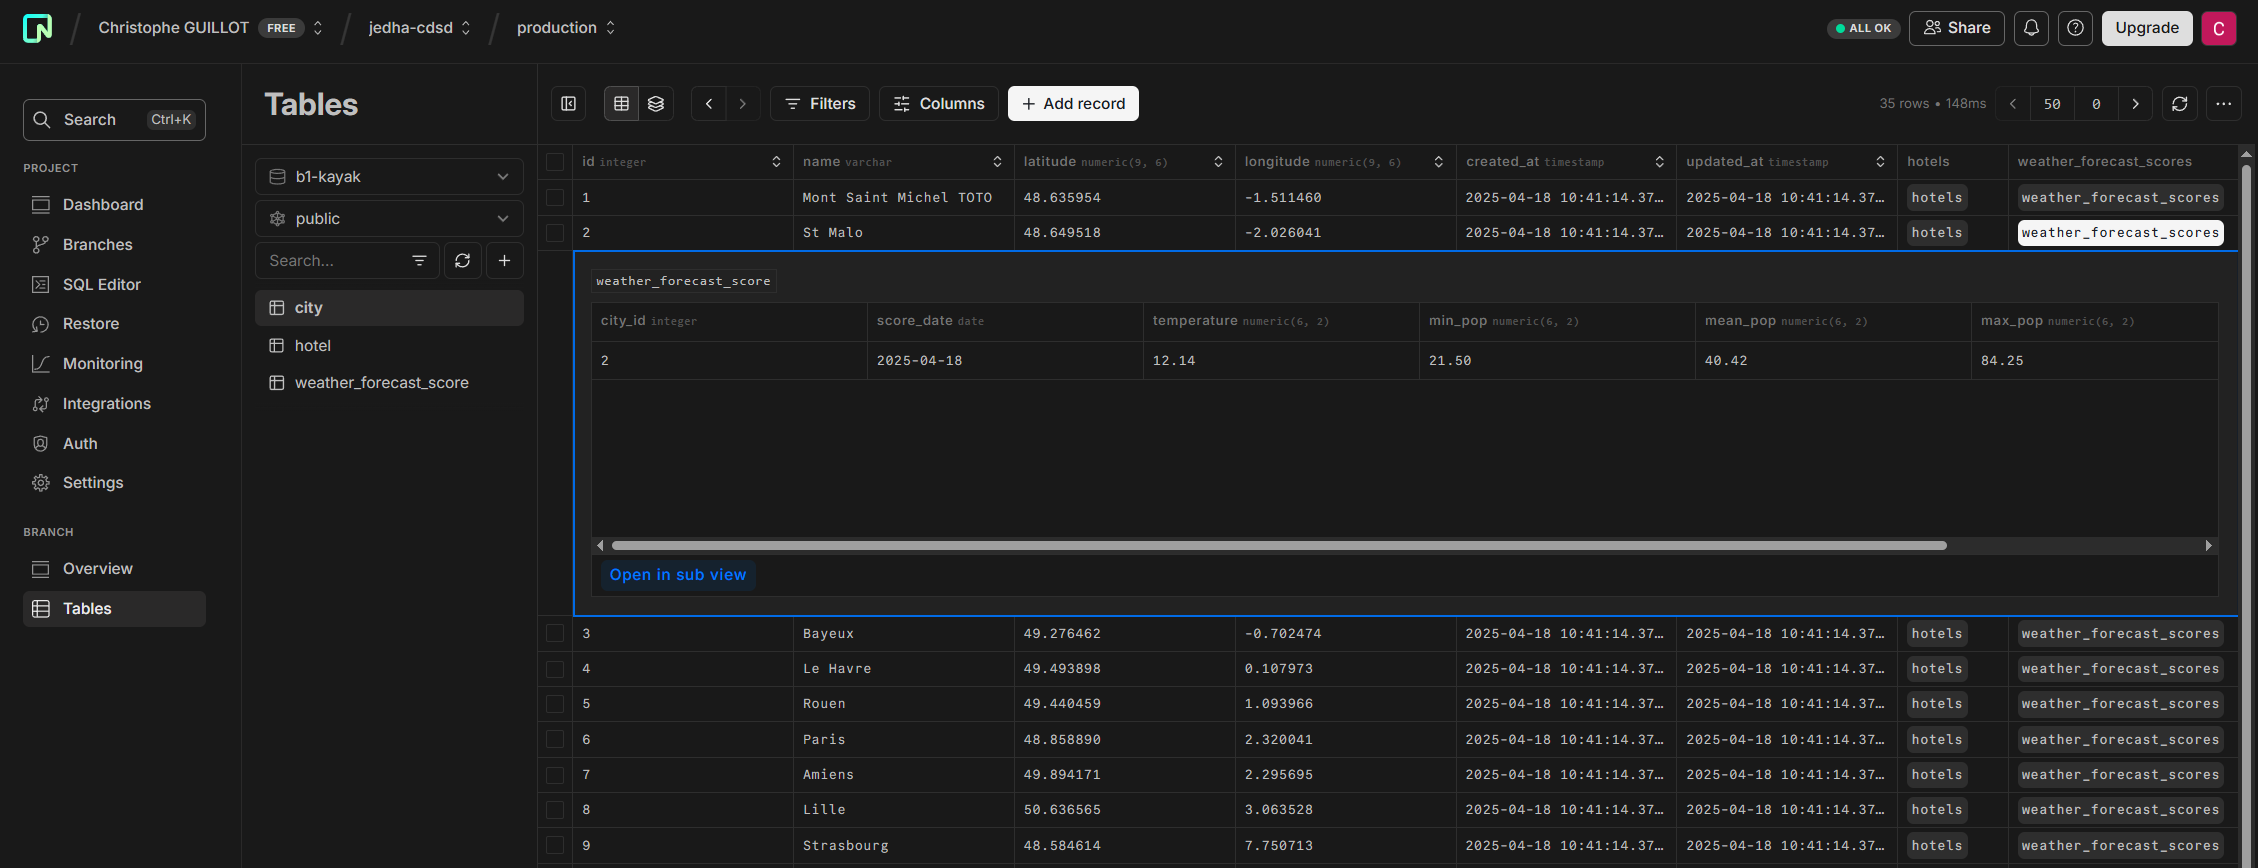